# Beat Tracking

## Imports

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

from sklearn.cluster import KMeans
from collections import Counter

import mir_eval

## Loading a file

First applying and demonstrating the pipeline for one file with visualization, towards the end will run for a set of files for a generalized evaluation

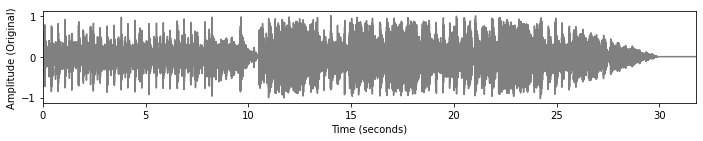

In [2]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Jive/Media-103713.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (Original)')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

83


[0.06, 0.4, 0.72, 1.06, 1.28, 1.72, 1.94, 2.44, 2.64, 3.12]

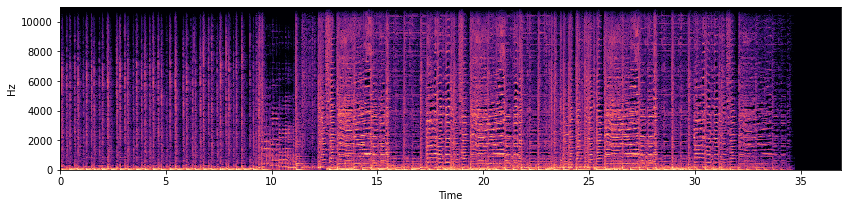

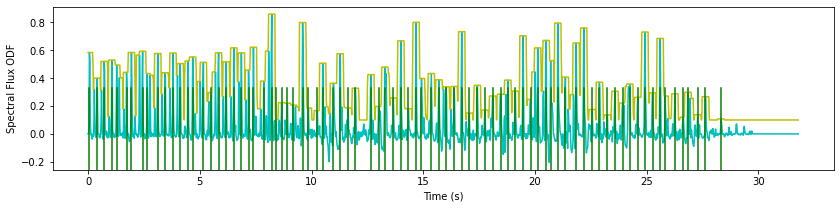

In [164]:
n = 2048
window = 'hann'
hop_length = 441

width = 15
threshold= 0.1

def detect_onsets(x, width, threshold, gamma=None, plot=False):
    # Short Fast Fourier Transform for spectrogram of audio
    
    D = np.abs(librosa.stft(x, window=window, hop_length=hop_length))  # STFT
    
    # Logarithmic compression (helps detect faded out beats, but overall distorts)
    if gamma:
        D = np.log(1 + gamma * D)
    
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    if plot:
        plt.figure(figsize=(14, 3))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
        
        
        plt.figure(figsize=(14, 3))
        plt.xlabel('Time (s)')
        plt.ylabel('Spectral Flux ODF')
        plt.plot(t, odf_med, 'c')
        plt.plot(t, thresholds, 'y')
        
        for p in peak_times:
           plt.axvline(p, ymax=0.5, color='g')
        
    
    return peak_times
    
onsets = detect_onsets(x, width=width, threshold=threshold, plot=True)
print(len(onsets))
list(onsets[:10])

## IOI Clustering

[0.34, 4.42, 8.16, 13.6, 20.44]

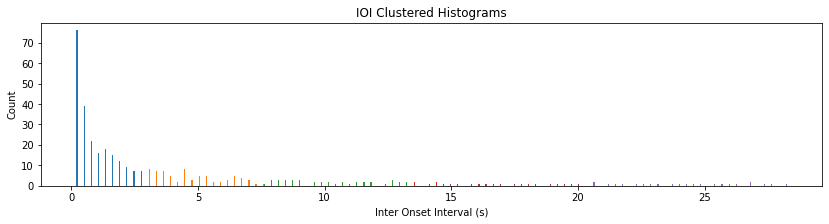

In [143]:
def ioi_clustering(onsets, n_clusters=6, limit_tempo=None, plot=False):
    
    # Compute all possible inter onset intervals
    ioi = []
    for i in range(1, len(onsets)):
        for j in range(i, len(onsets), i):
            ioi_instance = onsets[j] - onsets[j-i]

            # Limits possible iois by tempo if range is specified
            if limit_tempo:
                tempo = 60/ioi_instance
                if tempo >= limit_tempo[0] and limit_tempo[1] <= 280:
                    ioi.append(ioi_instance)
            else:
                ioi.append(ioi_instance)

    temp = np.array(ioi).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp)
    
    # Construct clusters array and sort for convinience
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(ioi[i])
    clusters = sorted(clusters)
    
    if plot:
        plt.figure(figsize=(14, 3))
        plt.title('IOI Clustered Histograms')
        plt.xlabel('Inter Onset Interval (s)')
        plt.ylabel('Count')
        plt.hist(clusters, 100)  
    
    # Find the mode of each cluster
    ioi_common = []
    for clust in clusters:
        dict_counter = Counter()
        for x  in clust:
            dict_counter[round(x, 4)] += 1
    
        ioi_common.append(dict_counter.most_common()[0][0])
        
    return clusters, ioi_common
    
ioi_clusters, ioi_common = ioi_clustering(onsets, n_clusters= 5, plot=True)  # have the option to limit tempo
ioi_common

## Periodicity function

In [135]:
# Compute ratios between common iois or tempos
def ratio_matrix(x):
    ratios = []
    for i in range(len(x)):
        ratios.append([])
        for j in range(len(x)):
            ratios[i].append(x[i]/x[j])
            
    return ratios

ratios = ratio_matrix(ioi_common)
print(np.array(ioi_common))
print()
for l in ratios:
    print(np.around(np.array(l),2))

[ 0.34  4.42  8.16 13.6  20.44]

[1.   0.08 0.04 0.02 0.02]
[13.    1.    0.54  0.32  0.22]
[24.    1.85  1.    0.6   0.4 ]
[40.    3.08  1.67  1.    0.67]
[60.12  4.62  2.5   1.5   1.  ]


## Agent Voting

In [136]:
class Agent:
  def __init__(self, direction, ioi, start):
    self.direction = direction 
    self.ioi = ioi
    self.start = start
    self.predictions = []  # beat predictions
    self.error = []  # error of beats from closest onset
    
# Agent hypothesises beat path from start to finish
def agent_forward_pass(ioi, i, onsets, max_time):
    a = Agent( 'forward', ioi, onsets[i])
            
    state = a.start    
    while state < max_time:
        # jump by the hypothesised ioi
        a.predictions.append(state)

        # Compute error from state to closest onset
        distances = np.array([abs(state - x) for x in onsets])
        a.error.append(min(distances))
        
        state += ioi
        
    return a

# Agent hypothesises beat path from end to beginning
def agent_backward_pass(ioi, i, onsets):
    a = Agent('backward', ioi, onsets[-i])
            
    state = a.start    
    while state > 0:
        # jump by the hypothesised ioi
        a.predictions.append(state)

        # Compute error from state to closest onset
        distances = np.array([abs(state - x) for x in onsets])
        a.error.append(min(distances))
        
        state -= ioi
        
    return a
    

# Multiple agents hypothesise beat paths, to later be evaluated somewhat "democratically"
def agent_voting(onsets, ioi_common, bidirectional=True):
    
    max_time = len(x) / sr
    agents = []
    
    prev = 0
    
    # Number of agents proportionate to number of clusters common ioi and starting onsets
    # Loops through common iois, and all possible start points
    for ioi in ioi_common:
        for i in range(len(onsets)//2): # takes first half of onsets as potential starts 
            
            # Create, execute and store new agents
            agents.append(agent_forward_pass(ioi, i, onsets, max_time))
            if bidirectional: agents.append(agent_backward_pass(ioi, i, onsets))
                
    return agents

agents = agent_voting(onsets, ioi_common)  # have the option to test both directions
print(len(agents), 'agents have voted in this song\'s election.')

410 agents have voted in this song's election.


Its interesting to note that larger iois overall have less onset errors.

In [146]:
# Counts all the votes and processes accordingly for results
def beat_election(agents, threshold=0.1):
    vote_counter = Counter()
    elected_beats = []
    
    # Compute the score based on count and onset error
    for a in agents:
        for i, p in enumerate(a.predictions):
            vote_counter[round(p, 3)] += 1 / (a.error[i] + 0.001)
            
    # Min, max normalisation, and elect above a specified threshold
    mini = vote_counter.most_common()[-1][1]
    maxi = vote_counter.most_common()[0][1]
    
    for key, score in vote_counter.items():
        score = (score - mini) / (maxi - mini)
        vote_counter[key] = score

        if score >= threshold:
            elected_beats.append(key)
            
    return sorted(elected_beats), vote_counter.most_common()
    
estimated_beats, election_results = beat_election(agents)
print(estimated_beats)
election_results[:30]

[0.06, 0.4, 0.72, 1.06, 1.28, 1.72, 1.94, 2.44, 2.64, 3.12, 3.44, 3.8, 4.12, 4.48, 4.68, 5.16, 5.52, 5.84, 6.18, 6.52, 6.86, 7.18, 7.4, 7.86, 8.22, 8.4, 8.66, 8.92, 9.18, 9.6, 9.86, 10.26, 10.5, 10.98, 11.28, 11.64, 11.96, 12.66, 13.0, 13.28, 13.66, 14.0, 14.32, 14.68, 14.92, 15.36, 15.7, 16.02, 16.38, 16.72, 17.06, 17.42, 17.76, 18.1, 18.46, 18.78, 19.12, 19.46, 19.8, 20.12, 20.5, 20.7, 21.02, 21.36, 21.84, 22.18, 22.56, 22.88, 23.24, 23.58, 23.92, 24.24, 24.6, 24.92, 25.26, 25.6, 25.82, 26.26, 26.64, 26.84, 27.28, 27.62, 28.32]


[(11.28, 1.0),
 (14.68, 0.9999999999998221),
 (11.96, 0.999999999999763),
 (13.66, 0.9666663456257579),
 (15.7, 0.9666663456246332),
 (16.38, 0.933332691251575),
 (8.22, 0.8999990368779256),
 (15.36, 0.8999990368775703),
 (20.12, 0.8999990368759716),
 (10.26, 0.8666653825039797),
 (14.0, 0.8666653825035653),
 (17.42, 0.8333317281299747),
 (16.72, 0.8333317281298563),
 (6.86, 0.8333317281297677),
 (13.0, 0.8333317281289091),
 (6.52, 0.7999980737557034),
 (17.06, 0.7999980737555552),
 (17.76, 0.7999980737555552),
 (12.66, 0.7333307650068349),
 (18.78, 0.6999971106337181),
 (18.1, 0.6999971106337181),
 (11.64, 0.6999971106328299),
 (9.6, 0.6999971106321785),
 (5.52, 0.6999971106318232),
 (19.12, 0.6666634562596538),
 (5.84, 0.6666634562595947),
 (6.18, 0.6666634562595947),
 (8.92, 0.6666634562581142),
 (5.16, 0.6333298018855305),
 (4.48, 0.6333298018855008)]

## Results

OrderedDict([('F-measure', 0.7943262411347518),
             ('Cemgil', 0.7632629721390615),
             ('Cemgil Best Metric Level', 0.7632629721390615),
             ('Goto', 0.0),
             ('P-score', 0.7671232876712328),
             ('Correct Metric Level Continuous', 0.2054794520547945),
             ('Correct Metric Level Total', 0.6164383561643836),
             ('Any Metric Level Continuous', 0.2054794520547945),
             ('Any Metric Level Total', 0.6164383561643836),
             ('Information gain', 0.4182956241653072)])

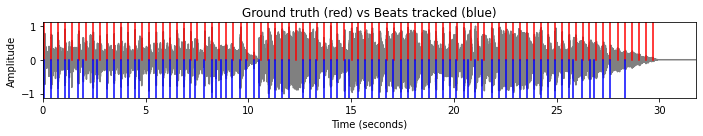

In [147]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-103713.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.display(ipd.Audio(x + y, rate=sr))

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))

# Generalizing to datasets

## Parameter Investigation

Investigating odf params

In [9]:
# TODO grid search for each investigationg maaaaybe?

## Comparison

In [10]:
# TODO